In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, roc_auc_score, average_precision_score, confusion_matrix
from pathlib import Path
import json
import time

ROOT = Path.cwd().parent
DATA_DIR = ROOT / "data" / "processed" / "stage1_sampled"

STAGE1_DIR = ROOT / "S1"
MODEL_DIR = STAGE1_DIR / "model"
NORM_DIR = STAGE1_DIR / "normalizer"
RESULTS_DIR = STAGE1_DIR / "results"
SPLITS_DIR = STAGE1_DIR / "splits"

for d in [MODEL_DIR, NORM_DIR, RESULTS_DIR, SPLITS_DIR]:
    d.mkdir(parents=True, exist_ok=True)


In [2]:
X = np.load(DATA_DIR / "X_sampled.npy").astype(np.float32)
y = np.load(DATA_DIR / "y_sampled.npy").astype(np.float32)

print(f"Loaded X={X.shape}, y={y.shape}")


Loaded X=(131398, 77), y=(131398,)


In [3]:
# 15% Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# 15% Validation from remaining 85%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)


In [4]:
np.save(SPLITS_DIR / "X_train.npy", X_train)
np.save(SPLITS_DIR / "X_val.npy",   X_val)
np.save(SPLITS_DIR / "X_test.npy",  X_test)
np.save(SPLITS_DIR / "y_train.npy", y_train)
np.save(SPLITS_DIR / "y_val.npy",   y_val)
np.save(SPLITS_DIR / "y_test.npy",  y_test)


In [5]:
eps = 1e-15
mean = X_train.mean(axis=0)
min_ = X_train.min(axis=0)
max_ = X_train.max(axis=0)

def normalize(x):
    return (x - mean) / (max_ - min_ + eps)

X_train = normalize(X_train).astype(np.float32)
X_val   = normalize(X_val).astype(np.float32)
X_test  = normalize(X_test).astype(np.float32)


In [6]:
np.savez(
    NORM_DIR / "jumabek_normalizer.npz",
    mean=mean, min=min_, max=max_, eps=eps
)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

BATCH_SIZE = 1024

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)


In [8]:
class Stage1MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)


In [9]:
benign = (y_train == 0).sum()
malicious = (y_train == 1).sum()
pos_weight = torch.tensor(benign / malicious, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

model = Stage1MLP(X_train.shape[1]).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=5, factor=0.5
)


In [10]:
def evaluate(model, loader):
    model.eval()
    probs, labels = [], []
    loss_sum = 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y.unsqueeze(1))
            loss_sum += loss.item() * x.size(0)

            probs.extend(torch.sigmoid(logits).cpu().numpy().flatten())
            labels.extend(y.cpu().numpy())

    probs = np.array(probs)
    labels = np.array(labels)

    return {
        "loss": loss_sum / len(labels),
        "recall": recall_score(labels, probs >= 0.5),
        "auc": roc_auc_score(labels, probs),
        "auc_pr": average_precision_score(labels, probs),
        "probs": probs,
        "labels": labels
    }


In [11]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_auc": [],
    "val_auc": []
}

for epoch in range(100):
    model.train()
    train_probs, train_labels = [], []
    train_loss_sum = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * x.size(0)

        p = torch.sigmoid(logits).detach().cpu().numpy().flatten()
        train_probs.extend(p)
        train_labels.extend(y.cpu().numpy())

    # ح Train metrics
    train_loss = train_loss_sum / len(train_labels)
    train_auc = roc_auc_score(train_labels, train_probs)

    # Validation
    val_metrics = evaluate(model, val_loader)
    scheduler.step(val_metrics["loss"])

    # save values
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_metrics["loss"])
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_metrics["auc"])

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train Loss={train_loss:.4f} | "
        f"Val Loss={val_metrics['loss']:.4f} | "
        f"Train AUC={train_auc:.4f} | "
        f"Val AUC={val_metrics['auc']:.4f}"
    )
# Always save final model
torch.save(model.state_dict(), MODEL_DIR / "stage1_model.pth")
print("✔ Stage 1 model saved")



Epoch 001 | Train Loss=0.0047 | Val Loss=0.0014 | Train AUC=0.9707 | Val AUC=0.9976
Epoch 002 | Train Loss=0.0023 | Val Loss=0.0008 | Train AUC=0.9922 | Val AUC=0.9989
Epoch 003 | Train Loss=0.0017 | Val Loss=0.0006 | Train AUC=0.9955 | Val AUC=0.9996
Epoch 004 | Train Loss=0.0014 | Val Loss=0.0007 | Train AUC=0.9967 | Val AUC=0.9993
Epoch 005 | Train Loss=0.0012 | Val Loss=0.0005 | Train AUC=0.9979 | Val AUC=0.9996
Epoch 006 | Train Loss=0.0010 | Val Loss=0.0004 | Train AUC=0.9985 | Val AUC=0.9997
Epoch 007 | Train Loss=0.0010 | Val Loss=0.0003 | Train AUC=0.9983 | Val AUC=0.9997
Epoch 008 | Train Loss=0.0009 | Val Loss=0.0009 | Train AUC=0.9987 | Val AUC=0.9998
Epoch 009 | Train Loss=0.0009 | Val Loss=0.0003 | Train AUC=0.9986 | Val AUC=0.9997
Epoch 010 | Train Loss=0.0008 | Val Loss=0.0004 | Train AUC=0.9989 | Val AUC=0.9998
Epoch 011 | Train Loss=0.0009 | Val Loss=0.0002 | Train AUC=0.9986 | Val AUC=0.9998
Epoch 012 | Train Loss=0.0008 | Val Loss=0.0002 | Train AUC=0.9990 | Val AUC

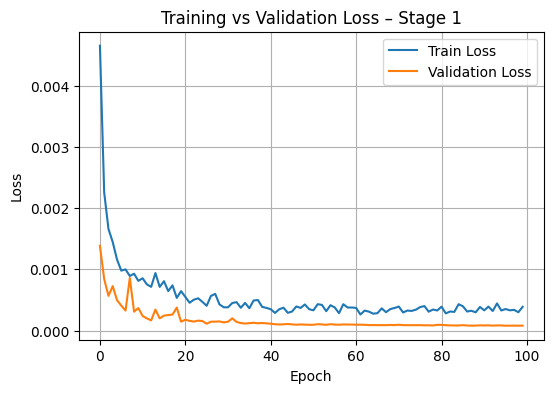

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss – Stage 1")
plt.legend()
plt.grid(True)
plt.show()


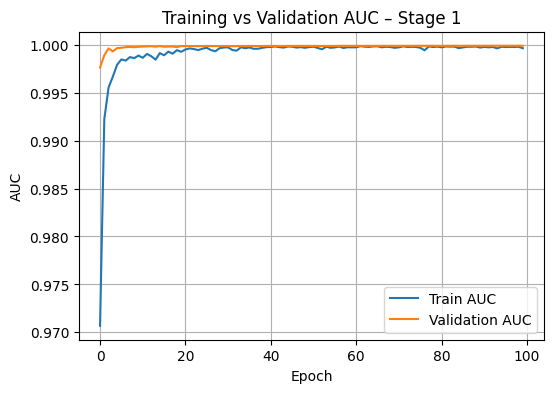

In [13]:
plt.figure(figsize=(6,4))
plt.plot(history["train_auc"], label="Train AUC")
plt.plot(history["val_auc"], label="Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC – Stage 1")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
val_metrics  = evaluate(model, val_loader)
test_metrics = evaluate(model, test_loader)

print("\n" + "=" * 60)
print("📊 FINAL STAGE 1 RESULTS")
print("=" * 60)

print("Validation:")
print(f"  AUC-ROC : {val_metrics['auc']:.4f}")
print(f"  AUC-PR  : {val_metrics['auc_pr']:.4f}")
print(f"  Loss    : {val_metrics['loss']:.4f}")

print("\nTest:")
print(f"  AUC-ROC : {test_metrics['auc']:.4f}")
print(f"  AUC-PR  : {test_metrics['auc_pr']:.4f}")
print(f"  Loss    : {test_metrics['loss']:.4f}")



📊 FINAL STAGE 1 RESULTS
Validation:
  AUC-ROC : 0.9999
  AUC-PR  : 1.0000
  Loss    : 0.0001

Test:
  AUC-ROC : 1.0000
  AUC-PR  : 1.0000
  Loss    : 0.0001


In [15]:
def json_safe(o):
    if isinstance(o, np.ndarray):
        return o.tolist()
    if isinstance(o, (np.float32, np.float64)):
        return float(o)
    if isinstance(o, dict):
        return {k: json_safe(v) for k, v in o.items()}
    if isinstance(o, list):
        return [json_safe(v) for v in o]
    return o


In [16]:
with open(RESULTS_DIR / "training_history.json", "w") as f:
    json.dump(json_safe(history), f, indent=2)

with open(MODEL_DIR / "stage1_metadata.json", "w") as f:
    json.dump({
        "input_dim": X_train.shape[1],
        "normalization": "jumabek",
        "loss": "BCEWithLogits(pos_weight)",
        "batch_size": BATCH_SIZE,
        "device": str(device)
    }, f, indent=2)


# LOAD

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix


In [18]:
# Load saved splits
X_test = np.load(SPLITS_DIR / "X_test.npy")
y_test = np.load(SPLITS_DIR / "y_test.npy")

# Load normalizer
norm = np.load(NORM_DIR / "jumabek_normalizer.npz")
mean, min_, max_, eps = norm["mean"], norm["min"], norm["max"], norm["eps"]

def normalize(x):
    return (x - mean) / (max_ - min_ + eps)

X_test = normalize(X_test).astype(np.float32)


In [19]:
model = Stage1MLP(X_test.shape[1]).to(device)
model.load_state_dict(
    torch.load(MODEL_DIR / "stage1_model.pth", map_location=device)
)
model.eval()


Stage1MLP(
  (net): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=77, out_features=128, bias=True)
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [20]:
# Get TEST probabilities
with torch.no_grad():
    logits = model(torch.from_numpy(X_test).to(device))
    test_probs = torch.sigmoid(logits).cpu().numpy().flatten()


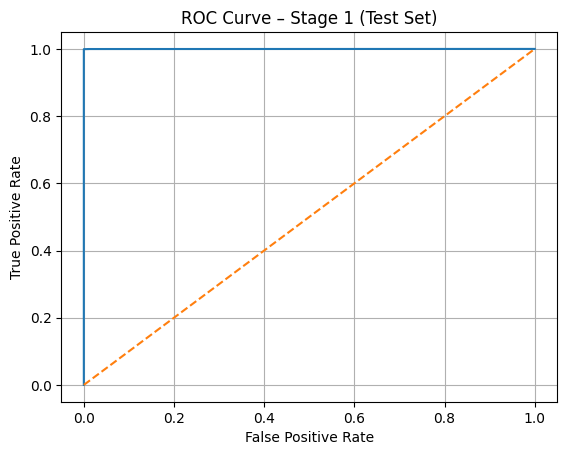

In [21]:
fpr, tpr, roc_thresholds = roc_curve(y_test, test_probs)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Stage 1 (Test Set)")
plt.grid(True)
plt.show()


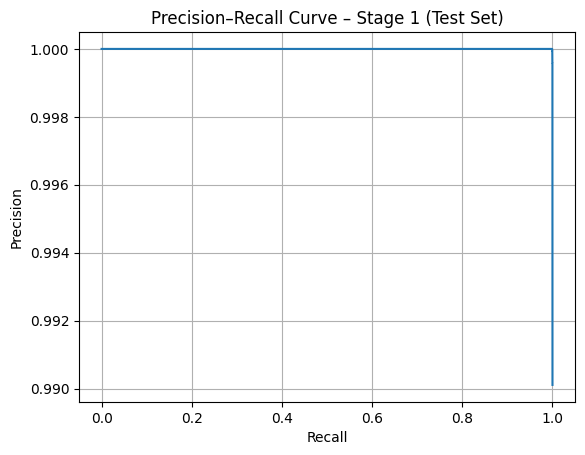

In [22]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_probs)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Stage 1 (Test Set)")
plt.grid(True)
plt.show()


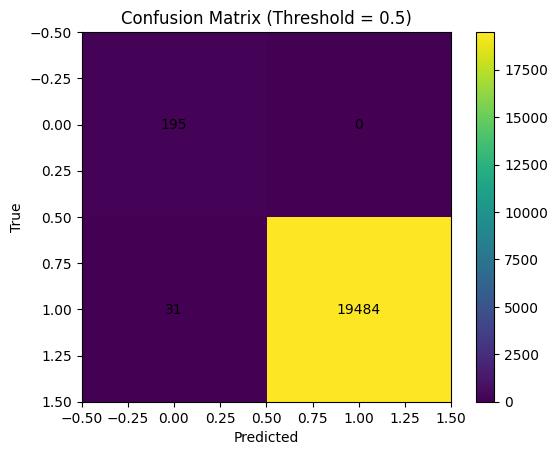

In [23]:
preds_05 = (test_probs >= 0.5).astype(int)
cm = confusion_matrix(y_test, preds_05)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


In [37]:
benign_probs = test_probs[y_test == 0]
malicious_probs = test_probs[y_test == 1]

print("Benign probability range:")
print(f"  min = {benign_probs.min()}")
print(f"  max = {benign_probs.max():.4f}")

print("\nMalicious probability range:")
print(f"  min = {malicious_probs.min()}")
print(f"  max = {malicious_probs.max()}")


Benign probability range:
  min = 2.9830440325895324e-05
  max = 0.0661

Malicious probability range:
  min = 0.0001548498694319278
  max = 0.9999563694000244


In [38]:
T_benign = benign_probs.max()
T_malicious = malicious_probs.min()

print(f"Benign upper bound      : {T_benign}")
print(f"Malicious lower bound   : {T_malicious}")


Benign upper bound      : 0.06606882810592651
Malicious lower bound   : 0.0001548498694319278


In [39]:
zones = np.zeros_like(test_probs, dtype=int)

zones[test_probs <= T_benign] = 0      # Benign
zones[test_probs >= T_malicious] = 2   # Malicious
zones[(test_probs > T_benign) & (test_probs < T_malicious)] = 1  # Suspicious


In [40]:
unique, counts = np.unique(zones, return_counts=True)
zone_counts = dict(zip(unique, counts))

print("\nZone distribution on TEST:")
print(f"Benign     : {zone_counts.get(0,0)}")
print(f"Suspicious : {zone_counts.get(1,0)}")
print(f"Malicious  : {zone_counts.get(2,0)}")



Zone distribution on TEST:
Benign     : 133
Suspicious : 0
Malicious  : 19577


In [41]:
T_malicious = benign_probs.max()
T_benign = malicious_probs.min()

print(f"T_malicious = {T_malicious}")
print(f"T_benign    = {T_benign}")



T_malicious = 0.06606882810592651
T_benign    = 0.0001548498694319278


In [44]:
# 0 = Benign, 1 = Suspicious, 2 = Malicious
zone_preds = np.zeros_like(test_probs, dtype=int)

zone_preds[test_probs < T_benign] = 0
zone_preds[test_probs > T_malicious] = 2
zone_preds[(test_probs >= T_benign) & (test_probs <= T_malicious)] = 1


In [45]:
cm = np.zeros((2, 3), dtype=int)

for true, pred in zip(y_test.astype(int), zone_preds):
    cm[true, pred] += 1

cm


array([[  133,    62,     0],
       [    0,    13, 19502]])

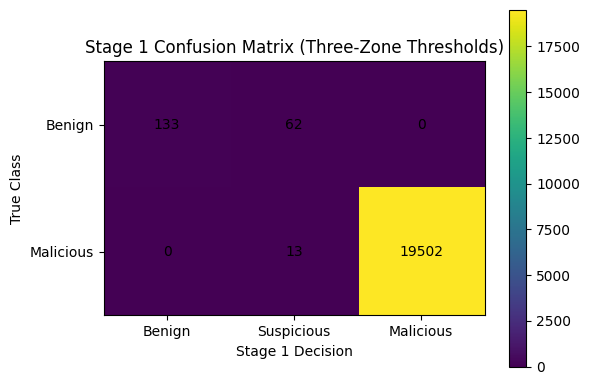

In [46]:
plt.figure(figsize=(6,4))
plt.imshow(cm)
plt.colorbar()

plt.xticks([0,1,2], ["Benign", "Suspicious", "Malicious"])
plt.yticks([0,1], ["Benign", "Malicious"])

plt.xlabel("Stage 1 Decision")
plt.ylabel("True Class")
plt.title("Stage 1 Confusion Matrix (Three-Zone Thresholds)")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [47]:
benign_leakage = cm[0, 2] / cm[0].sum()       # benign sent as malicious
malicious_miss = cm[1, 0] / cm[1].sum()       # malicious sent as benign
suspicious_rate = cm[:,1].sum() / cm.sum()   # traffic forwarded to stage 2

print(f"Benign → Malicious leakage : {benign_leakage:.6f}")
print(f"Malicious → Benign miss    : {malicious_miss:.6f}")
print(f"Suspicious traffic rate    : {suspicious_rate:.6f}")


Benign → Malicious leakage : 0.000000
Malicious → Benign miss    : 0.000000
Suspicious traffic rate    : 0.003805


# --------------------------------